In [10]:
#import libraries
import os
import pandas as pd
import string
from sklearn.utils import shuffle
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud     #Install wordcloud using conda using 'conda install -c conda-forge wordcloud'
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.pipeline import Pipeline
import itertools
from datetime import datetime
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [2]:
#Read data

folder = os.getcwd()
Fake_data_file_name = 'Fake.csv'
True_data_file_name = 'True.csv'

if os.path.isfile(Fake_data_file_name):
    fake = pd.read_csv(Fake_data_file_name)
else:
    print ("Error: Fake.csv does not exist in ", folder)
    
if os.path.isfile(True_data_file_name):
    true = pd.read_csv(True_data_file_name)
else:
    print ("Error: True.csv does not exist in ", folder)




In [3]:
# Flag added to differentiate fake and true data
fake['target'] = 'FAKE'
true['target'] = 'TRUE'

In [4]:
data = pd.concat([fake, true]).reset_index(drop = True)

# Shuffle data to prevent bias
data = shuffle(data)
data = data.reset_index(drop = True)

## Data Cleaning

In [5]:
# Data cleaning

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str


data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply(punctuation_removal)
data['subject'] = data['subject'].replace('politicsNews', 'politics')
data['subject'] = data['subject'].replace('_', '-')
data['date'] = data['date'].str.replace('Jan ', 'January ')
data['date'] = data['date'].str.replace('Feb ', 'February ')
data['date'] = data['date'].str.replace('Mar ', 'March ')
data['date'] = data['date'].str.replace('Apr ', 'April ')
data['date'] = data['date'].str.replace('Jun ', 'June ')
data['date'] = data['date'].str.replace('Jul ', 'July ')
data['date'] = data['date'].str.replace('Aug ', 'August ')
data['date'] = data['date'].str.replace('Sep ', 'September ')
data['date'] = data['date'].str.replace('Oct ', 'October ')
data['date'] = data['date'].str.replace('Nov ', 'November ')
data['date'] = data['date'].str.replace('Dec ', 'December ')
data.date = data.date.str.strip()
data = data[data.date.str.len() < 18]
data.date = data.date.apply(lambda x: datetime.strptime(x, "%B %d, %Y") if (len(x) > 9 & len(x) < 18) else datetime.strptime(x, "%d-%b-%y"))

stop = stopwords.words('english')
# remove stopwords
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [6]:
data['year'] = data['date'].dt.to_period('Y')
data['month'] = data['date'].dt.to_period('M')
data['month'] = data['month'].astype(str)


## Data Exploration

subject
Government News     1480
Middle-east          731
News                8646
US_News              736
left-news           4210
politics           17073
worldnews           8250
Name: text, dtype: int64


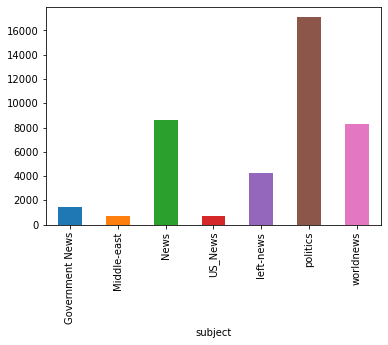

In [7]:
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

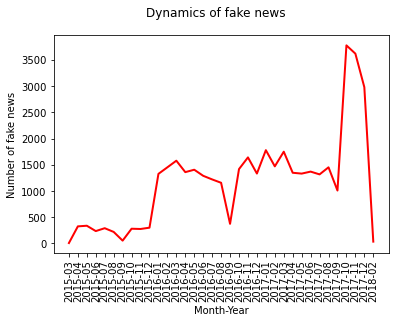

In [8]:

monthly_data = data.groupby(['month'])['text'].count()
plt.suptitle('Dynamics of fake news')
plt.xticks(rotation=90)
plt.ylabel('Number of fake news')
plt.xlabel('Month-Year')
plt.plot(monthly_data.index, monthly_data.values, linewidth=2, color='red')
plt.show()

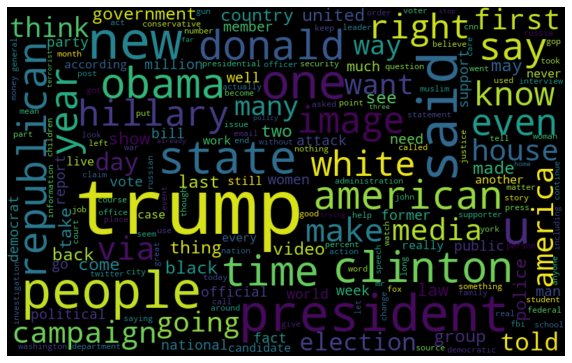

In [7]:
# Wordcloud for Fake News
fake_data = data[data["target"] == "FAKE"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud_fake = WordCloud(width= 800, height= 500, max_font_size = 110, collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis("off")
plt.show()

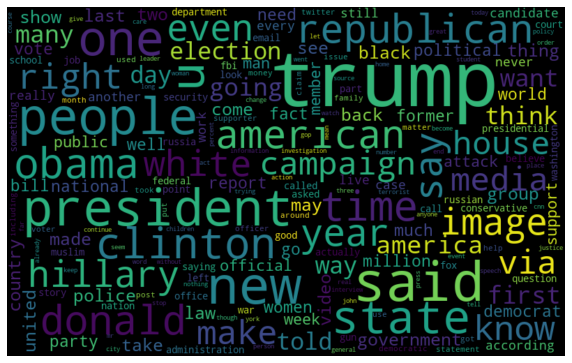

In [8]:
# Wordcloud for True News
real_data = data[data['target'] == 'TRUE']
all_words = ' '.join([text for text in fake_data.text])

wordcloud_true = WordCloud(width= 800, height= 500, max_font_size = 110, collocations = False).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud_true, interpolation='bilinear')
plt.axis("off")
plt.show()

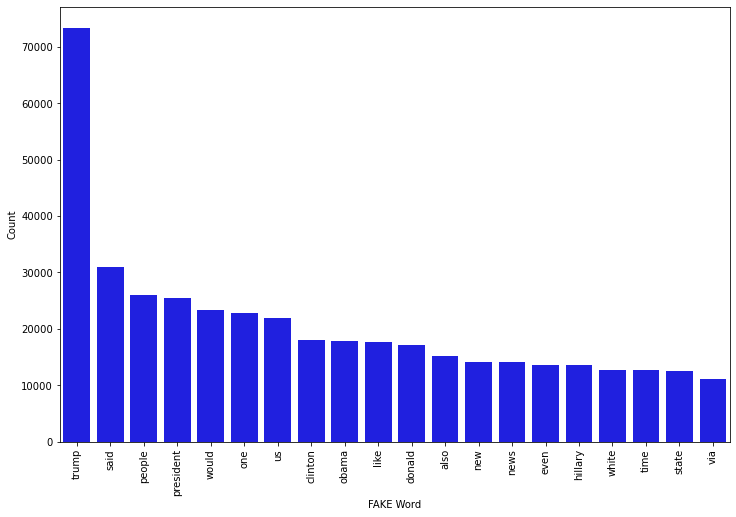

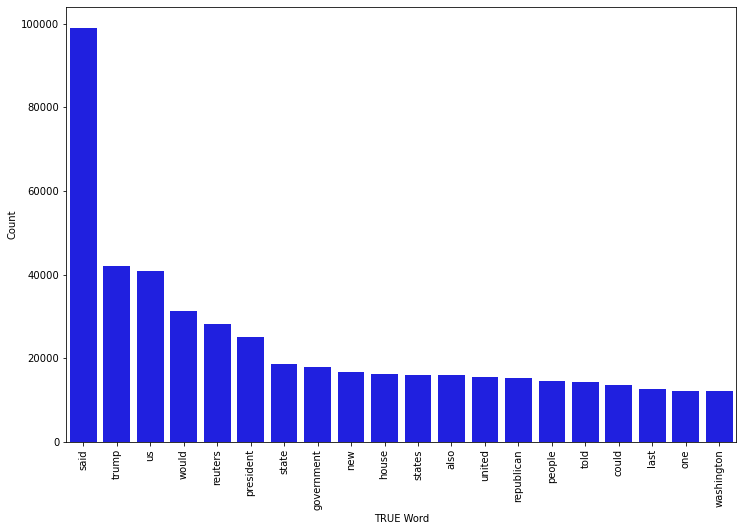

In [9]:
token_space = tokenize.WhitespaceTokenizer()
def counter(text, column_text, quantity, category):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                 "Frequency": list(frequency.values())})    
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count", xlabel = (category + " Word"))
    plt.xticks(rotation='vertical')
    plt.show()
    
counter(data[data["target"] == "FAKE"], "text", 20, "FAKE")
counter(data[data["target"] == "TRUE"], "text", 20, "TRUE")

## Data Modelling

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [28]:
data["target2"] = data["target"].apply(lambda x: 0 if x == "FAKE" else 1)
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target2, test_size=0.2, random_state=42)

In [29]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])
# Fitting the model
model = pipe.fit(X_train, y_train)
# Accuracy
prediction = model.predict(X_test)

print("accuracy: {}%".format(round(metrics.accuracy_score(y_test, prediction)*100,2)))

accuracy: 98.92%


In [10]:
data

,title,text,subject,date,target
0,Tapper SLAMS Trump For BIZARRE Behavior At ‘W...,certainly love lost cnn trump administration i...,News,"February 16, 2017",FAKE
1,Republicans Look To Shut Down The Government ...,republicans 2016 presidential election well be...,News,"December 9, 2016",FAKE
2,Factbox: About 5.8 million without power in U....,reuters power outages hurricane irma dropped 5...,worldnews,"September 12, 2017",TRUE
3,Maine governor says he will not expand Medicai...,reuters maine governor paul lepage said wednes...,politics,"November 8, 2017",TRUE
4,Trump Administration Is Already Talking About...,national day prayer donald trump lashed south ...,News,"September 3, 2017",FAKE
5,DISGRACEFUL: US Air Force Can No Longer Afford...,afford give us veterans proper funeral got mon...,left-news,"Jan 1, 2016",FAKE
6,"Undeterred By Threats Of GOP Obstruction, Oba...",president obama clearly letting gop threats ob...,News,"March 9, 2016",FAKE
7,OUTRAGEOUS VIDEOS: WATCH THE LEFTISTS BLAME TH...,point alan dershowitz made absurd comment earl...,left-news,"May 9, 2015",FAKE
8,"Elizabeth Warren Tears Trump Apart AGAIN, Pra...",sen elizabeth warren roll brutal eviscerations...,News,"March 25, 2016",FAKE
9,Trump backers sue San Jose for allowing 'mob' ...,reuters police california city san jose motiva...,politics,"July 15, 2016",TRUE


In [30]:
clf = LinearSVC(max_iter=100, C=1.0)
clf.fit(X_train, y_train)

y_pred_SVM = clf.predict(X_test)
print(cross_val_score(clf, X_text, data['target'], cv=3))
print(accuracy_score(y_pred_SVM, y_test))

scores['LinearSVC'] = accuracy_score(y_pred_SVM, y_test)

ValueError: could not convert string to float: 'washington reuters us republican presidential candidate donald trump monday rejected barrage criticism party allegations bias hispanic judge insisting concerns valid “all want figure i’m treated unfairly judge lot people agree it” trump said fox news trump defensive since comments last week mexicanamerican us district judge gonzalo curiel overseeing fraud lawsuits trump university new york businessman’s defunct real estate school also castigated democrats including party’s likely presidential nominee hillary clinton “i don’t know else could call attacks racist prejudiced bigoted” clinton said interview msnbc monday “it’s plain wrong certainly wrong coming someone vying become president united states” trump told campaign supporters conference call stand attacks judge bloomberg politics reported said call trump distanced memo campaign sent supporters sunday urged avoid issue asked comment trump spokeswoman hope hicks said “it positive call discuss overall messaging” two trump supporters tana goertz scottie nell hughes told cnn former arizona governor jan brewer said call wanted campaign go offense expected democratic nominee hillary clinton goertz said trump told suppporters afraid “call media” tv reporters suggest trump racist trump suggested curiel’s heritage influencing judge’s opinion case trump’s campaign rhetoric illegal immigration trump presumptive republican nominee nov 8 presidential election pledged seal usmexico border wall said mexico sending rapists drug dealers united states former republican presidential candidate marco rubio us senator florida joined chorus criticism interview orlando’s wftv rubio called trump’s comments wrong said stop “i ran president warned going happen” rubio said trump regularly stirred controversy campaign trail frequently dismayed republican establishment leaders view ethnically biased judiciary drawn fresh wave criticism including concern party sunday asked token believed muslim judge would biased based trump’s call temporary ban muslims entering country “it’s possible yes” trump said cbs’ “face nation” republican leaders including house representatives speaker paul ryan senate republican leader mitch mcconnell distanced trump’s comments saying worried tone presidential campaign could enrage latinos growing us voting bloc “if doesn’t change we’re big trouble” senator jeff flake arizona republican said msnbc monday “i hope able support nominee certainly can’t now” said flake whose state large percentage hispanics former rival republican presidential nomination ohio governor john kasich called trump apologize curiel born indiana mexican immigrant parents “attacking judges based race andor religion another tactic divides country” kasich wrote twitter “more importantly flat wrong” unclear effect latest furor would trump’s unorthodox candidacy states significant hispanic populations including california new mexico new jersey hold nominating contests tuesday trump fought back republican critics monday especially sharp words newt gingrich former house speaker gingrich mentioned possible running mate trump sunday called trump’s comments inexcusable “i surprised newt” trump told “fox friends” program “i thought inappropriate said”'

In [34]:
data.astype("string")

TypeError: data type "string" not understood